In [1]:
import os
import sys
import argparse

print(os.getcwd())
os.chdir("../../")
os.getcwd()

sys.argv = ["view", "--config", "config/single_task_attribute_prediction.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

/data01/dl23vitcas/dl_project/src/single_task_attribute_prediction
config/single_task_attribute_prediction.yaml


In [2]:
from config_experiments import config
from torchvision.transforms import transforms
from dataloader import VOC08Attr
import matplotlib.pyplot as plt
from model import AttributePredictionModel
from utils import set_device
import torch
import matplotlib.patches as patches

In [3]:
transform_val = transform = transforms.Compose(
    [
        transforms.Resize(
            size=config["transform"]["resize_values"],
            max_size=config["transform"]["max_size"],
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)

In [4]:
model_path = "../dl_project/experiments/attribute_prediction/2024-07-29_17-54-07/models/best_model_epoch_20.pth"

device = set_device(config["global"]["gpu_id"])
model = AttributePredictionModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [5]:
val_data = VOC08Attr(train=False, transform=None)
val_data_for_model = VOC08Attr(train=False, transform=transform_val)

In [47]:
def inference(idx):
    img_transform, _, _, gt_bbox_transform, _, _ = val_data_for_model[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    gt_bbox_transform = gt_bbox_transform.to(device)

    image, _, gt_class, gt_bbox, gt_attributes, _ = val_data[idx]

    indices_batch = torch.zeros(gt_bbox_transform.shape[0], device=device).unsqueeze(-1)
    pred_attr, pred_score_attr = model.prediction_rois(
        img_transform, gt_bbox_transform, indices_batch
    )
    return (
        image,
        gt_bbox,
        gt_class,
        gt_attributes,
        pred_attr.cpu(),
        pred_score_attr.cpu(),
    )


def get_names_attributes(attributes):
    indices = torch.nonzero(attributes == 1.0, as_tuple=True)[0] + 1
    return [val_data.id2attribute[(idx)] for idx in indices.tolist()]


def plot_inference(image, gt_bbox, gt_class, gt_attributes, pred_attr, pred_score_attr):
    im = image
    fig, ax = plt.subplots()
    ax.imshow(im)

    for gt_el in gt_bbox:
        x_min, y_min, x_max, y_max = gt_el

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)

    for i, (box, c, attr) in enumerate(zip(gt_bbox, gt_class, gt_attributes)):
        print("\nBOX:\n")
        print(f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]})")
        print(f"GT Attributes:  {get_names_attributes(attr)}")
        print(f"NET Attributes:  {get_names_attributes(pred_attr[i])}")

    plt.show()

IDX: 421


BOX:

tensor([209,  53, 432, 359], dtype=torch.int32) 	 class: 2 (person)
GT Attributes:  ['Occluded', 'Head', 'Ear', 'Nose', 'Mouth', 'Hair', 'Face', 'Torso', 'Hand', 'Arm', 'Skin', 'Cloth']
NET Attributes:  ['Occluded', 'Head', 'Ear', 'Nose', 'Mouth', 'Hair', 'Face', 'Eye', 'Torso', 'Hand', 'Arm', 'Skin', 'Cloth']

BOX:

tensor([449, 184, 500, 275], dtype=torch.int32) 	 class: 10 (chair)
GT Attributes:  ['3D Boxy', 'Occluded', 'Furn. Leg', 'Furn. Back', 'Furn. Seat', 'Furn. Arm', 'Plastic']
NET Attributes:  ['3D Boxy', 'Furn. Leg', 'Furn. Back', 'Furn. Seat', 'Furn. Arm', 'Plastic', 'Wood']

BOX:

tensor([  1, 188, 184, 267], dtype=torch.int32) 	 class: 10 (chair)
GT Attributes:  ['Occluded', 'Furn. Back', 'Furn. Arm', 'Plastic']
NET Attributes:  ['3D Boxy', 'Occluded', 'Furn. Back', 'Plastic', 'Wood']

BOX:

tensor([  1, 264, 394, 375], dtype=torch.int32) 	 class: 11 (diningtable)
GT Attributes:  ['Round', 'Occluded', 'Plastic', 'Shiny']
NET Attributes:  ['Occluded', 'Woo

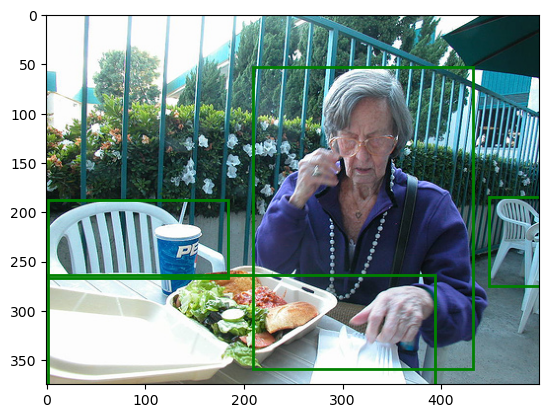

In [46]:
idx = torch.randint(low=0, high=len(val_data), size=(1,))

print(f"IDX: {idx.item()}\n")
image, gt_bbox, gt_class, gt_attributes, pred_attr, pred_score_attr = inference(idx=idx)
plot_inference(image, gt_bbox, gt_class, gt_attributes, pred_attr, pred_score_attr)

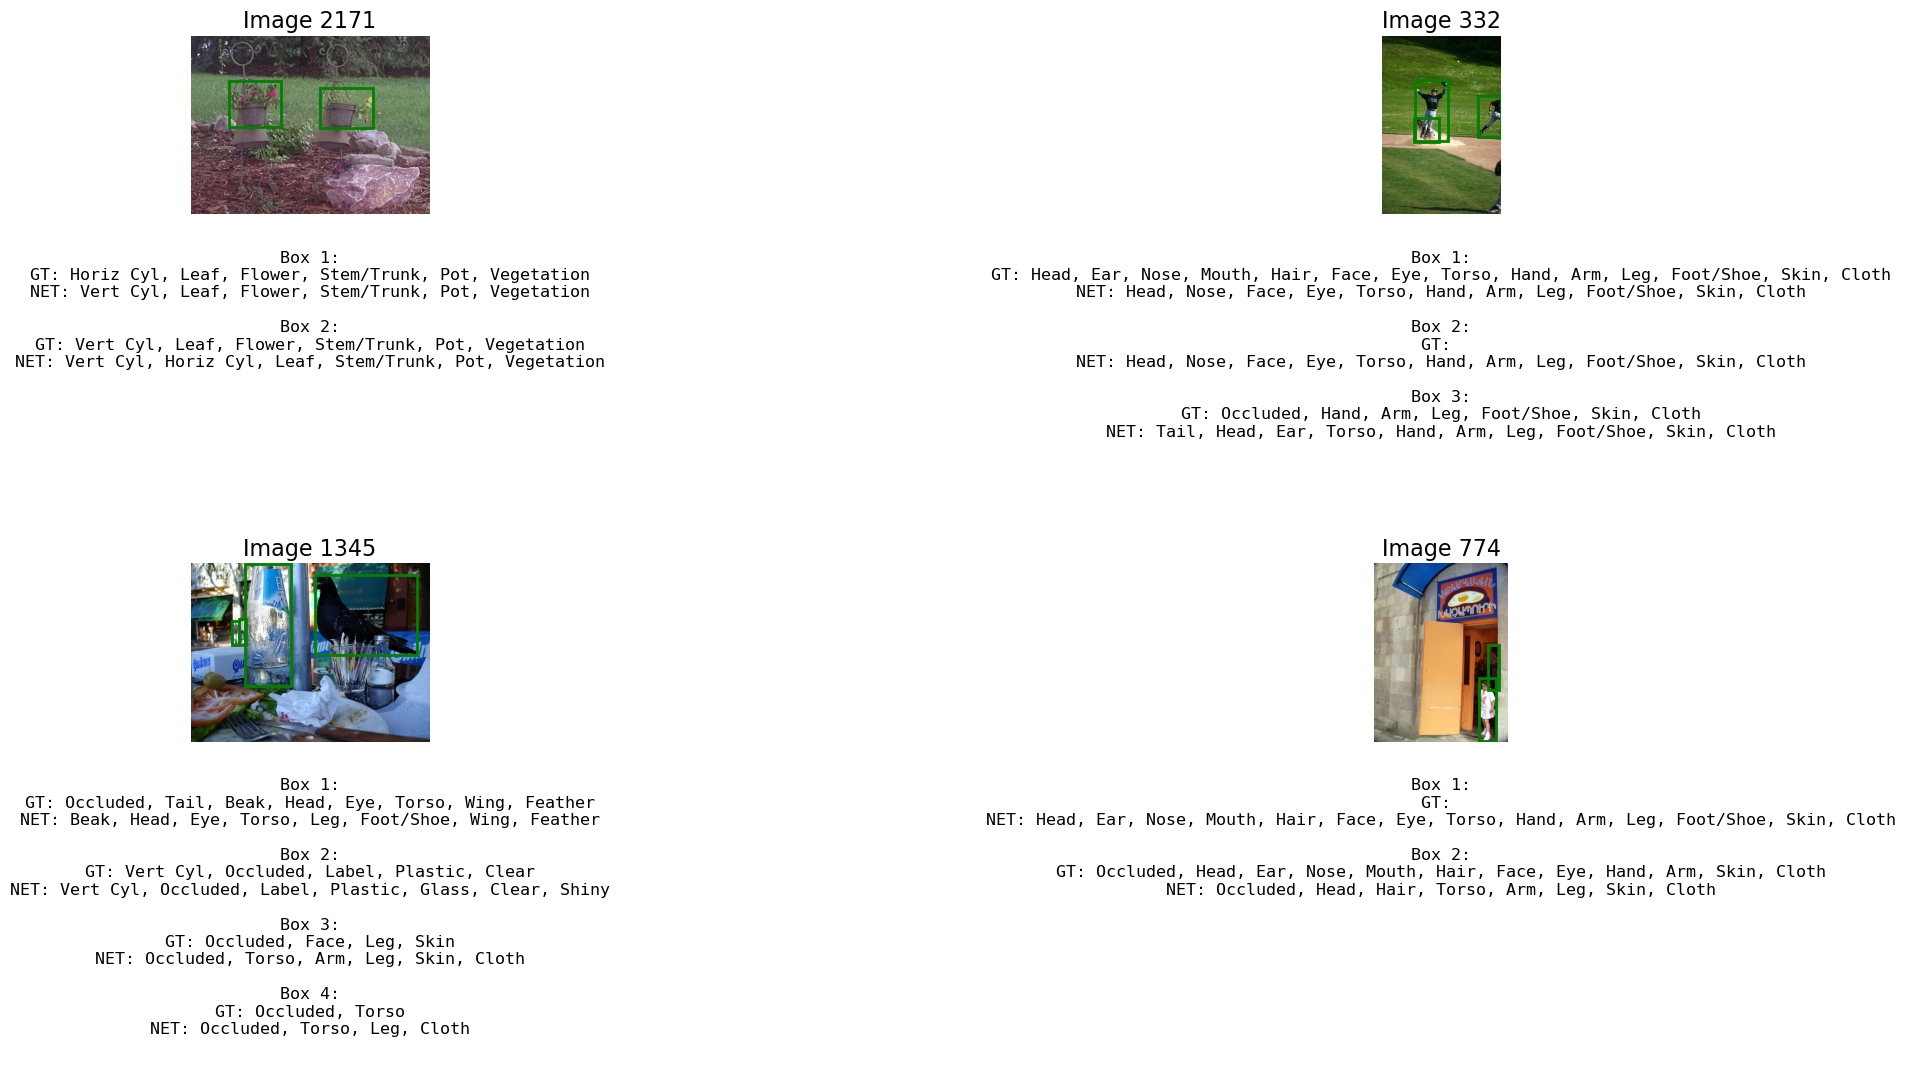

In [68]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def inference(idx):
    img_transform, _, _, gt_bbox_transform, _, _ = val_data_for_model[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    gt_bbox_transform = gt_bbox_transform.to(device)

    image, _, gt_class, gt_bbox, gt_attributes, _ = val_data[idx]

    indices_batch = torch.zeros(gt_bbox_transform.shape[0], device=device).unsqueeze(-1)
    pred_attr, pred_score_attr = model.prediction_rois(
        img_transform, gt_bbox_transform, indices_batch
    )
    return (
        image,
        gt_bbox,
        gt_class,
        gt_attributes,
        pred_attr.cpu(),
        pred_score_attr.cpu(),
    )


def get_names_attributes(attributes):
    indices = torch.nonzero(attributes == 1.0, as_tuple=True)[0] + 1
    return [val_data.id2attribute[(idx)] for idx in indices.tolist()]


def plot_multiple_inferences(num_images=8):
    rows = 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
    axes = axes.flatten()

    for i in range(num_images):
        idx = torch.randint(low=0, high=len(val_data), size=(1,)).item()
        image, gt_bbox, _, gt_attributes, pred_attr, _ = inference(idx=idx)

        ax = axes[i]
        ax.imshow(image)

        # Plot GT bounding boxes
        for gt_el in gt_bbox:
            x_min, y_min, x_max, y_max = gt_el
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)

        # Prepare the attribute group for each bounding box
        table_info = ""
        for j, (gt_attr, net_attr) in enumerate(zip(gt_attributes, pred_attr)):
            gt_attr_names = ", ".join(get_names_attributes(gt_attr))
            net_attr_names = ", ".join(get_names_attributes(net_attr))
            table_info += f"Box {j+1}:\nGT: {gt_attr_names}\nNET: {net_attr_names}\n\n"

        # Handling cases where there are more GT attributes than predicted
        for j in range(len(gt_attributes) - len(pred_attr)):
            gt_attr_names = ", ".join(
                get_names_attributes(gt_attributes[len(pred_attr) + j])
            )
            table_info += (
                f"Box {len(pred_attr) + j + 1}:\nGT: {gt_attr_names}\nNET: N/A\n\n"
            )

        ax.axis("off")
        ax.set_title(f"Image {idx}", fontsize=16)

        # Add text below the image using ax.text
        ax.text(
            0.5,
            -0.2,
            table_info,
            fontsize=12,
            ha="center",
            va="top",
            transform=ax.transAxes,
            family="monospace",
        )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Display 4 images in a 2x2 grid
plot_multiple_inferences(num_images=4)